<a href="https://colab.research.google.com/github/NTT123/ai-notebooks/blob/master/Attention_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Implementation of Attention Sampling Network

From the paper **Processing Megapixel Images with Deep Attention-Sampling Models**.  Authors: Angelos Katharopoulos, François Fleure.

In this notebook, we generate a dataset of $1024 \times 1024$  images. These images contain random noise in the background and a MNIST image of size $28\times 28$ at a random location.

The attention sampling network will look at a low resolution version ($64 \times 64$)  of these images, and output a probability distribution of locations at which the network wants to see the high resolution input (cropped samples of size $64 \times 64$).

These high resolution samples go through a CNN to extract features. The final feature vector is the expectation of these extracted features.

This feature vector goes through a linear function for digit classification.


### MegaMNIST dataset 



In [2]:
#@title
%%writefile mnist.py
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
import random

class MegaMNIST(Dataset):
    def __init__(self, size):
        super().__init__()
        self.size = size
        self.dataset = MNIST(root="/tmp/mnist", train=True,
                             download=True, transform=T.ToTensor())
        self.resize = T.Compose([
            T.ToPILImage(),
            T.Resize(64),
            T.ToTensor(),
        ])

    def __len__(self):
        return 5000 # len(self.dataset)

    def __getitem__(self, idx):
        frame = torch.rand(1, self.size, self.size) 
        x = random.randint(28, self.size-2*28)
        y = random.randint(28, self.size-2*28)
        fs = self.dataset[idx][0]
        fs = (fs + torch.rand_like(fs))
        frame[:, x:x+28, y:y+28] = fs
        frame = frame / 2
        small_frame = self.resize(frame)

        return small_frame, frame, self.dataset[idx][1]

Writing mnist.py


Label 5


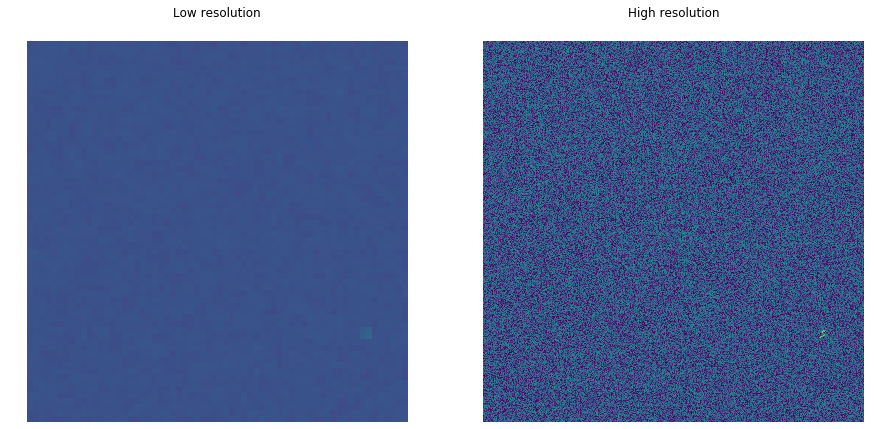

In [3]:
#@title
from google.colab import output
from mnist import MegaMNIST
import matplotlib.pyplot as plt
data = MegaMNIST(1024)
small, large,label = data[0]

from pylab import rcParams
rcParams['figure.figsize'] = 15, 30

ax = plt.subplot(1, 2, 1)
ax.matshow(small[0], vmin=0, vmax=1)
ax.set_title("Low resolution")
plt.axis("off")
ax = plt.subplot(1,2, 2)
ax.matshow(large[0], vmin=0, vmax=1)
ax.set_title("High resolution")
_ = plt.axis("off")
output.clear()
print("Label {}".format(label))

### Models

In [4]:
%%writefile models.py
from torch.distributions.categorical import Categorical
from torch.autograd import Function
import torch.nn as nn
import torch


def init_weights(m):
    if type(m) == nn.Conv2d:
        # m.bias.data.fill_(0)
        nn.init.kaiming_normal_(
            m.weight.data, mode='fan_in', nonlinearity='relu')


class FarCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.F = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
        )

        self.hardtanh = nn.Hardtanh(-5, 5)     # [-5, 5]
        self.F.apply(init_weights)

    def forward(self, x):
        x = self.F(x).squeeze(1)
        x = x.view(x.size(0), -1)
        x = self.hardtanh(x)
        return x


class NearCNN(nn.Module):
    def __init__(self, ft_dim):
        super().__init__()
        self.ft_dim= ft_dim
        self.F = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, ft_dim, kernel_size=5, bias=False),
            nn.BatchNorm2d(ft_dim),
        )
        self.F.apply(init_weights)

    def forward(self, x):
        x = self.F(x)
        x = x.view(x.size(0), x.size(1))
        n = x.norm(dim=-1, keepdim=True)
        return x/n


class Expectation(Function):
    @staticmethod
    def forward(ctx, log_probs, features):
        ctx.save_for_backward(log_probs, features)
        #log_probs: [batch, K]
        #features: [batch, ft_dim, K]
        return features.mean(dim=-1)

    @staticmethod
    def backward(ctx, grad_output):
        # grad_output: [batch, ft_dim]
        _, features = ctx.saved_tensors
        K = features.size(2)
        grad_ft = grad_output.unsqueeze(2).expand_as(features) ## need / K, maybe not!
        a = grad_ft * features
        a = a.sum(dim=1)
        return a, grad_ft

exfn = Expectation.apply


class AttSampling(nn.Module):
    def __init__(self, K, s, h, w, zoom=1024//64, ft_dim=64):
        super().__init__()
        self.attNet = FarCNN()
        self.featureNet = NearCNN(ft_dim)
        self.K = K
        self.s = s
        self.h = h
        self.w = w
        self.zoom=zoom
        self.ft_dim = ft_dim
        self.linear_clf = nn.Linear(ft_dim, 10)

    def forward(self, x_small, x_large):
        dist = self.attNet(x_small)
        cat = Categorical(logits=dist)
        pos = cat.sample((self.K,))
        large_input = nn.functional.pad(
            x_large, (self.s//2, self.s//2, self.s//2, self.s//2))
        rows = pos.div(self.h)
        cols = pos.remainder(self.w)
        bs = x_small.size(0)
        small_batch = torch.empty( (1, self.s, self.s, bs, self.K))
        for b in range(bs):
            for i in range(self.K):
                r, c = rows[i, b], cols[i, b]
                r = r.item() * self.zoom
                c = c.item() * self.zoom

                small_batch[:, :, :, b, i] = large_input[b, :,  r:r+self.s, c:c+self.s]

        x, y, z, _, _ = small_batch.size()
        small_batch = small_batch.view(x, y, z, -1).permute(3, 0, 1, 2)
        features = self.featureNet(small_batch.to(x_small.device))
        logpr = cat.log_prob(pos).permute(1, 0)
        features_ = features.permute(1, 0).view(self.ft_dim, bs, self.K).permute(1, 0, 2)
        avg_features = exfn(logpr, features_)
        predict = self.linear_clf(avg_features)
        return predict, cat.entropy(), dist


Writing models.py


### Training

In [5]:
!pip install -q fire

     |████████████████████████████████| 81kB 5.1MB/s 


In [6]:
%%writefile train.py
import fire
import torch
import torch.nn as nn
from mnist import MegaMNIST
from models import AttSampling
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader


def train(h=64, w=64, K=8, s=64, log_id=15, ent_reg=1e-5, lr=1e-3):
    """ Train an attention sampling network
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    att = AttSampling(K=K, s=s, h=h, w=w).to(device)
    writer = SummaryWriter("./logs/{}".format(log_id))
    st = 1
    optimizer = Adam(att.parameters(), lr=lr)
    data = MegaMNIST(1024)
    dataloader = DataLoader(data, batch_size=16, shuffle=True)
    num_epoch = 100
    tt = len(dataloader) * num_epoch

    for epoch in range(num_epoch):
        for x_small, x_large, y in dataloader:
            predict, ent, _ = att(x_small.to(device), x_large)
            loss = nn.functional.cross_entropy(predict, y.to(device=device))
            loss = loss - ent.mean() * ent_reg
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            writer.add_scalar("loss", loss.item(), st)

            print("\r [{:7.3f}% ] loss: {:7.4f}".format(st*100/tt, loss.item()), end="")
            writer.add_scalar("entropy", ent.mean().item(), st)
            st = st + 1


if __name__ == '__main__':
    fire.Fire(train)


Writing train.py


### Run

In [0]:
! python3 train.py --K=16 --log_id=1_bn_hardtanh5_ndivK

 [  7.288% ] loss:  0.7312

In [0]:
%load_ext tensorboard 

In [0]:
%tensorboard --logdir ./logs --port 1235